## API Script to fetch Paragliding Flights

This script is seperated into five parts:

1. Flights metadata are scraped. The year must be specified (in this analysis 2022-2024), the country is always set to Austria. The flight metadata is scraped as HTML page by page (50 per page) and stored in a JSON file. 

2. Correctly parse the stored HTML input and save it as a dataframe. 

3. Clean and filter the dataframe

4. Display the distributions of the data scraped

5. Store the cleaned data as a csv file for later analysis, by appending the loaded flights to the master file metadata.csv

In [ ]:
# 0. Load packages

import re
import time
import json
import requests
from bs4 import BeautifulSoup
from pathlib import Path
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import pandas as pd


In [ ]:
# 1. Load raw metadata of flights and store as JSON 
## adjust the year as needed (here used for sufficient flights 2022-2024)

BASE = "https://www.paraglidingforum.com"
LOGIN_URL = f"{BASE}/login.php"
REDIRECT_TO = "index.php"

UA = (
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:142.0) "
    "Gecko/20100101 Firefox/142.0"
)

session = requests.Session()
session.headers.update({
    "User-Agent": UA,
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.7",
})

def login(username: str, password: str) -> None:
    r1 = session.get(f"{LOGIN_URL}?redirect={REDIRECT_TO}", timeout=30)
    r1.raise_for_status()

    data = {
        "username": username,
        "password": password,
        "redirect": REDIRECT_TO,
        "login": "Log in",
    }
    headers = {
        "Origin": BASE,
        "Referer": f"{LOGIN_URL}?redirect={REDIRECT_TO}",
        "Content-Type": "application/x-www-form-urlencoded",
    }
    r2 = session.post(LOGIN_URL, data=data, headers=headers, allow_redirects=False, timeout=30)
    if r2.status_code != 302 or "Location" not in r2.headers:
        raise RuntimeError(f"Login failed: status={r2.status_code}")

    loc = r2.headers["Location"]
    if loc.startswith("http://"):
        r3 = session.get(loc, allow_redirects=True, timeout=30)
    else:
        r3 = session.get(BASE + "/" + loc.lstrip("/"), allow_redirects=True, timeout=30)
    r3.raise_for_status()

    print("✅ Logged in.")


def fetch_tracks_page(page_num=1, country="AT", year=2024):
    url = (
        f"{BASE}/leonardo/tracks/{country}/{year}/"
        "brand:all,cat:0,class:all,xctype:all,club:all,pilot:0_0,takeoff:all"
        f"&sortOrder=DATE&page_num={page_num}"
    )

    r = session.get(url, timeout=30)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    rows_data = []
    rows = soup.find_all("tr", id=re.compile(r"^row_"))  # only actual flight rows
    for row in rows:
        rows_data.append(str(row))  # store the full raw HTML string

    print(f"📄 Collected {len(rows_data)} raw rows on page {page_num} for year {year}")
    return rows_data


if __name__ == "__main__":
    USERNAME = "airmoritz"
    PASSWORD = "rka5BZG.hmt*tkw9wrb"

    login(USERNAME, PASSWORD)

    # Step 1: collect raw rows
    all_rows = []
    for page in range(1, 100):  # safety cap
        rows = fetch_tracks_page(page_num=page, country="AT", year=2022)

        if not rows:  # when the server returns no flights, stop
            print(f"⏹️ Done at page {page-1}")
            break

        all_rows.extend(rows)
        time.sleep(1)

    # Save raw rows
    out_json = Path("Flight data/raw_rows.json")
    out_json.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(all_rows, f, indent=2, ensure_ascii=False)

    print(f"💾 Saved {len(all_rows)} raw rows to {out_json}")


✅ Logged in.
📄 Collected 50 raw rows on page 1 for year 2022
📄 Collected 50 raw rows on page 2 for year 2022
📄 Collected 50 raw rows on page 3 for year 2022
📄 Collected 50 raw rows on page 4 for year 2022
📄 Collected 50 raw rows on page 5 for year 2022
📄 Collected 50 raw rows on page 6 for year 2022
📄 Collected 50 raw rows on page 7 for year 2022
📄 Collected 50 raw rows on page 8 for year 2022
📄 Collected 50 raw rows on page 9 for year 2022
📄 Collected 50 raw rows on page 10 for year 2022
📄 Collected 50 raw rows on page 11 for year 2022
📄 Collected 50 raw rows on page 12 for year 2022
📄 Collected 50 raw rows on page 13 for year 2022
📄 Collected 50 raw rows on page 14 for year 2022
📄 Collected 50 raw rows on page 15 for year 2022
📄 Collected 50 raw rows on page 16 for year 2022
📄 Collected 50 raw rows on page 17 for year 2022
📄 Collected 50 raw rows on page 18 for year 2022
📄 Collected 50 raw rows on page 19 for year 2022
📄 Collected 50 raw rows on page 20 for year 2022
📄 Collected 50 r

In [160]:
# 2. Parse JSON into a dataframe 

# Load the raw JSON with saved HTML rows
in_json = Path("Flight data/raw_rows.json")

# Load raw rows
with open(in_json, "r", encoding="utf-8") as f:
    raw_rows = json.load(f)


flights = []

for raw in raw_rows:   # <-- iterate over ALL saved rows
    row = BeautifulSoup(raw, "html.parser")
    cols = row.find_all("td")

    # Flight ID
    flight_id = None
    link = row.find("a", href=re.compile(r"/leonardo/flight/(\d+)"))
    if link:
        m = re.search(r"/leonardo/flight/(\d+)", link["href"])
        if m:
            flight_id = int(m.group(1))

    if not flight_id:   # skip rows without an ID
        continue

    # Pilot & Takeoff
    pilot = row.find("div", class_="pilotLink")
    pilot = pilot.get_text(strip=True) if pilot else ""

    takeoff = row.find("div", class_="takeoffLink")
    takeoff = takeoff.get_text(strip=True) if takeoff else ""

    # Extract glider info
    brand_td = row.find("td", align="center")

    # Extract glider info
    glider_img = row.select_one("img.brands")
    glider_title = glider_img.get("title") if glider_img else ""

    cat_div = row.find("div", class_="catInfo")
    glider_cat = ""
    if cat_div:
        img = cat_div.find("img")
        if img and img.has_attr("title"):
            glider_cat = img["title"]


    # Build dict
    flight = {
        "flight_id": flight_id,
        "index_cell": cols[0].get_text(strip=True) if len(cols) > 0 else "",
        "date": cols[1].get_text(strip=True) if len(cols) > 1 else "",
        "pilot": pilot,
        "takeoff": takeoff,
        "duration": cols[3].get_text(strip=True) if len(cols) > 3 else "",
        "open_distance": cols[4].get_text(strip=True) if len(cols) > 4 else "",
        "total_distance": cols[5].get_text(strip=True) if len(cols) > 5 else "",
        "xc_score": cols[6].get_text(strip=True) if len(cols) > 6 else "",
        "glider_cat": glider_cat,
        "glider_title": glider_title
    }

    flights.append(flight)

for row in raw_rows[:2]:
    print(row)
    print("=" * 80)  # separator line

# ✅ Now you should see row_3582459 first
print(flights[0])
print(flights[1])
print(flights[2])

import pandas as pd
df = pd.DataFrame(flights)
display(df.tail(9))

print(len(df))

<tr class="l_row1 newDate" id="row_3173751">
<td class="indexCell"><div>1</div> </td><td class="dateString" valign="top"><div>18/12/2022</div> </td><td class="pilotTakeoffCell" colspan="2"><div class="pilotLink" id="p_2"> <a href="javascript:pilotTip.newTip('inline', 0, 13, 'p_2', 250, '0_23373','&lt;img class=\'fl sprite-at\' src=\'/leonardo/img/space.gif\'  border=\'0\'  title=\'Austria\'  alt=\'Austria\'   align=\'absmiddle\' &gt;werner luidolt' )" onmouseout="pilotTip.hide()"><img align="absmiddle" alt="Austria" border="0" class="fl sprite-at" src="/leonardo/img/space.gif" title="Austria"/>werner luidolt</a>
</div><div class="takeoffLink" id="at_2"><a href="javascript:takeoffTip.newTip('inline',-25, 13,'t_2', 250, '43620','Lawinenstein - AT')" id="t_2" onmouseout="takeoffTip.hide()">Lawinenstein - AT</a>
</div></td><td>0:16</td><td class="distance">5.2 km</td><td class="distance">6.1 km</td><td class="OLCScore" nowrap="">9.16 <img align="top" alt="Free Flight" border="0" class="ico

,flight_id,index_cell,date,pilot,takeoff,duration,open_distance,total_distance,xc_score,glider_cat,glider_title
4357,2984021,4358,01/01/2022,Dirk Wilhelm,12er Kopf Zwoelferko... - AT,0:06,1.2 km,2.4 km,3.60,Paraglider -,Gin Bolero 6
4358,2984145,4359,01/01/2022,Peter Buschbacher,Elfer - AT,0:06,1.2 km,2.2 km,3.33,Paraglider - Open,Phi Maestro
4359,2984174,4360,01/01/2022,Thomas StÃ¶bich,Oedt - AT,0:21,0.4 km,2.2 km,3.26,Paraglider - Sport,Niviuk Artik 6
4360,2984181,4361,01/01/2022,Herbert Auberger,Oedt - AT,0:19,0.5 km,2.0 km,2.95,Paraglider -,Skywalk Tequila4
4361,2989637,4362,01/01/2022,Axel Heuchert,Hohe Salve - AT,0:22,0.4 km,1.7 km,2.48,Paraglider - Sport,Advance Sigma10 - 25 [LTF C]
4362,2984202,4363,01/01/2022,Wilhelm Leutgeb,Oedt - AT,0:14,0.3 km,1.6 km,2.35,Paraglider -,Niviuk ikuma - 27 [LTF B]
4363,2984233,4364,01/01/2022,Walter Altenhofer,Oedt - AT,0:07,0.4 km,1.5 km,2.30,Paraglider -,Ozone BZ5
4364,2984235,4365,01/01/2022,Manfred Starlinger,Oedt - AT,0:05,0.3 km,1.2 km,1.79,Paraglider -,PHI Maestro - 23
4365,3005864,4366,01/01/2022,Oliver Dippel,Hohe Salve - AT,0:05,0.1 km,0.5 km,0.82,Paraglider - Sport,Advance Xi


4366


In [161]:
# 3. Clean dataframe 

# Drop the pilot column
df = df.drop(columns=["pilot"], errors="ignore")

# Fix encoding issues for text columns
replacements = {
    "Ã¶": "ö",
    "Ã¼": "ü",
    "Ã¤": "ä",
    "ÃŸ": "ß"
}
for col in ["takeoff", "glider_title", "glider_cat"]:
    df[col] = df[col].replace(replacements, regex=True)

# --- Date to datetime ---
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y", errors="coerce")

# --- Duration (h:mm) into minutes ---
def parse_duration(x):
    if isinstance(x, str) and ":" in x:
        h, m = x.split(":")
        return int(h) * 60 + int(m)
    return None

df["duration_min"] = df["duration"].apply(parse_duration)

# --- Distances: clean and convert ---
for col in ["open_distance", "total_distance"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace("\xa0", " ", regex=False)   # replace non-breaking space
        .str.replace(" km", "", regex=False)
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# --- XC score: float ---
df["xc_score"] = pd.to_numeric(df["xc_score"].astype(str).str.replace("\xa0", "", regex=False), errors="coerce")


print(df.dtypes)
display(df.iloc[0:5])



flight_id                  int64
index_cell                object
date              datetime64[ns]
takeoff                   object
duration                  object
open_distance            float64
total_distance           float64
xc_score                 float64
glider_cat                object
glider_title              object
duration_min               int64
dtype: object


,flight_id,index_cell,date,takeoff,duration,open_distance,total_distance,xc_score,glider_cat,glider_title,duration_min
0,3173751,1,2022-12-18,Lawinenstein - AT,0:16,5.2,6.1,9.16,Paraglider - Sport,Nova MENTOR 7 Light,16
1,3165135,2,2022-12-13,Stubaital - Kreuzjoc... - AT,0:16,3.1,5.6,8.38,Paraglider - Sport,Nova ION 6 Light M,16
2,3165954,3,2022-11-27,Jakobshorn - AT,0:14,5.6,7.1,10.68,Paraglider - Sport,Ozone Swift 5,14
3,3148214,4,2022-10-29,Hahnenkamm (Reutte)... - AT [~1.4],1:49,5.9,20.4,40.87,Paraglider - Sport,Nova Xenon 17,109
4,3147152,5,2022-10-29,Hahnenkamm (Reutte)... - AT [~1.4],1:30,5.8,18.5,37.02,Paraglider - Open,Nova Xenon,90


In [162]:
# 3.1 Find and remove duplicate entries

def clean_flight_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans flight metadata by removing duplicates.
    Step 1: Drop duplicate flight_id values.
    Step 2: Drop duplicates based on metadata fields.
    """
    print(f"Starting dataset: {len(df)} rows")

    # Step 1: Ensure unique flight_id
    df = df.drop_duplicates(subset=["flight_id"]).reset_index(drop=True)
    print(f"After dropping duplicate flight_id: {len(df)} rows")

    # Step 2: Remove duplicates based on metadata fields
    meta_fields = ["date", "takeoff", "duration", "total_distance", "glider_title"]
    df = df.drop_duplicates(subset=meta_fields).reset_index(drop=True)
    print(f"After dropping metadata duplicates: {len(df)} rows")

    return df


df = clean_flight_metadata(df)
display(df.iloc[0:5])

Starting dataset: 4366 rows
After dropping duplicate flight_id: 4366 rows
After dropping metadata duplicates: 4316 rows


,flight_id,index_cell,date,takeoff,duration,open_distance,total_distance,xc_score,glider_cat,glider_title,duration_min
0,3173751,1,2022-12-18,Lawinenstein - AT,0:16,5.2,6.1,9.16,Paraglider - Sport,Nova MENTOR 7 Light,16
1,3165135,2,2022-12-13,Stubaital - Kreuzjoc... - AT,0:16,3.1,5.6,8.38,Paraglider - Sport,Nova ION 6 Light M,16
2,3165954,3,2022-11-27,Jakobshorn - AT,0:14,5.6,7.1,10.68,Paraglider - Sport,Ozone Swift 5,14
3,3148214,4,2022-10-29,Hahnenkamm (Reutte)... - AT [~1.4],1:49,5.9,20.4,40.87,Paraglider - Sport,Nova Xenon 17,109
4,3147152,5,2022-10-29,Hahnenkamm (Reutte)... - AT [~1.4],1:30,5.8,18.5,37.02,Paraglider - Open,Nova Xenon,90


In [ ]:
# 3.2 Check for NaN and Zero values

# --- 1. Count NaN values per column
nan_summary = df.isna().sum()
print("NaN values per column:\n", nan_summary)

# --- 2. Count 0 values per column (only for numeric columns)
zero_summary = (df.select_dtypes(include=["number"]) == 0).sum()
print("\nZero values per numeric column:\n", zero_summary)

# --- 3. Combine into one table
eda_summary = pd.DataFrame({
    "NaN_count": df.isna().sum(),
    "Zero_count": df.select_dtypes(include=["number"]).eq(0).sum()
})
display(eda_summary)

# --- 4. Inspect rows where critical fields are missing or zero
critical_cols = ["duration_min", "open_distance", "total_distance", "xc_score"]
faulty_rows = df[
    df[critical_cols].isna().any(axis=1) |
    (df[critical_cols] == 0).any(axis=1)
]
print(f"\nFound {len(faulty_rows)} faulty rows.")
display(faulty_rows.head(10))

NaN values per column:
 flight_id         0
index_cell        0
date              0
takeoff           0
duration          0
open_distance     0
total_distance    0
xc_score          0
glider_cat        0
glider_title      0
duration_min      0
dtype: int64

Zero values per numeric column:
 flight_id         0
open_distance     2
total_distance    0
xc_score          0
duration_min      5
dtype: int64


,NaN_count,Zero_count
date,0,NaN
duration,0,NaN
duration_min,0,5.0
flight_id,0,0.0
glider_cat,0,NaN
glider_title,0,NaN
index_cell,0,NaN
open_distance,0,2.0
takeoff,0,NaN
total_distance,0,0.0



Found 6 faulty rows.


,flight_id,index_cell,date,takeoff,duration,open_distance,total_distance,xc_score,glider_cat,glider_title,duration_min
1344,3041397,1373,2022-03-27,Hahnenkamm (Reutte)... - AT [~2.6],0:00,0.1,2.9,4.29,Paraglider - Sport,Advance Advanceiota26 - 26 [LTF 2],0
2489,3038687,2524,2022-03-11,Stubaital - Kreuzjoc... - AT,0:02,0.0,0.8,1.19,Paraglider -,Dudek Orca 4,2
2974,3020177,3015,2022-03-03,Stubaital - Kreuzjoc... - AT [~1.2],0:00,0.2,0.4,0.66,Paraglider - Sport,Ozone Delta 4,0
3005,3019357,3046,2022-03-02,Hochzeiger - AT [~3.3],0:00,0.1,0.2,0.28,Paraglider - Open,Ozone Mantra7 XS,0
3429,3007418,3474,2022-02-13,Niedere - AT,0:00,0.4,0.5,0.77,Paraglider -,Advance Alpha6 - 31 [LTF 1],0
4098,2992889,4146,2022-01-13,Bischling - AT,0:00,0.0,0.1,0.14,Paraglider -,Skywalk Breeze,0


In [ ]:
# 3.3 Filter for only confirmed paraglider flights (no fixed winds or unknown)

paragliders_df = df[df["glider_cat"].str.contains("Paraglider", na=False)]

print(f"Cleaned dataset: {len(paragliders_df)} rows (from {len(df)} originally).")

df = paragliders_df


Cleaned dataset: 3922 rows (from 4144 originally).


In [ ]:
# 3.4 Filter implausibly short flights

# Identify implausibly short flights (duration < 3 minutes OR distance < 1 km)
short_or_too_short_dist = df[(df["duration_min"] < 3) | (df["total_distance"] < 1) | (df["open_distance"] < 1) ]
print(f"Found {len(short_or_too_short_dist)} flights shorter than 3 minutes or <1 km distance.")

# Drop them
df_clean = df[
    (df["duration_min"] >= 3) &
    (df["total_distance"] >= 1) &
    (df["open_distance"] >= 1)
].reset_index(drop=True)

print(f"Cleaned dataset: {len(df_clean)} rows (from {len(df)} originally).")

df = df_clean

Found 172 flights shorter than 3 minutes or <1 km distance.
Cleaned dataset: 4144 rows (from 4316 originally).


/var/folders/zn/2ym95l4n2131dptxjp4dk3fh0000gn/T/ipykernel_42755/849661000.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_df = df[numeric_cols].applymap(lambda x: np.log1p(x) if pd.notnull(x) else x)


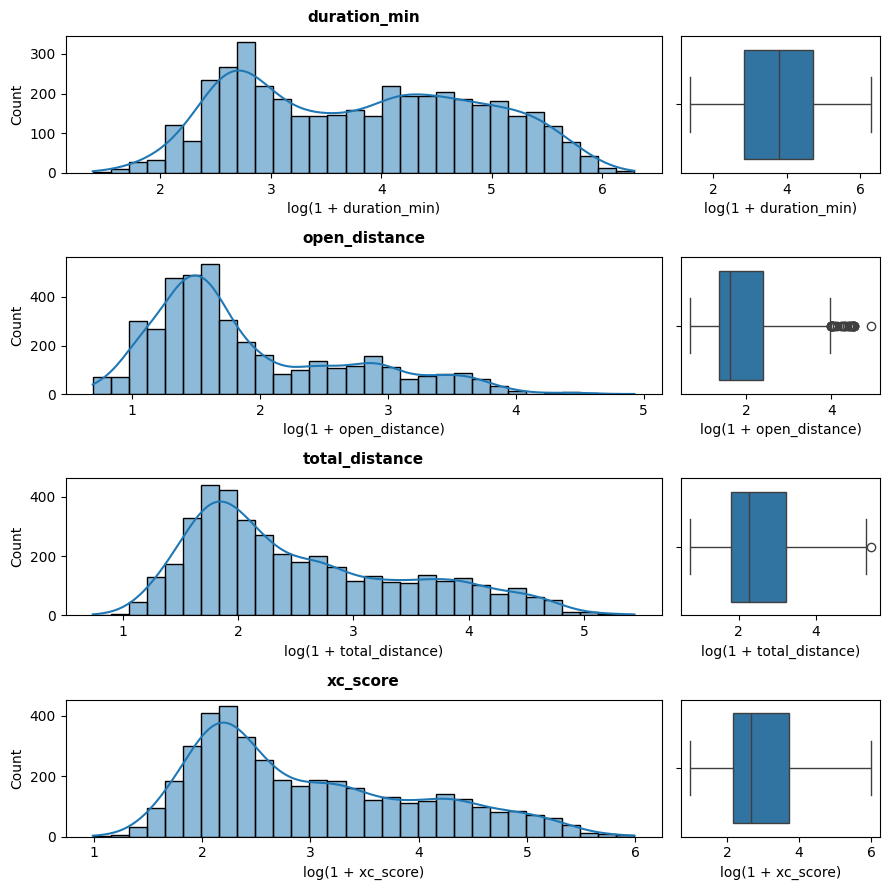

In [ ]:
# 4. Visualize loaded data (this is for all flights, incl missing IGC files which are later dropped)

# Pick numeric columns for EDA
numeric_cols = ["duration_min", "open_distance", "total_distance", "xc_score"]

# Apply log1p (log(1+x)) to avoid issues with 0 values
log_df = df[numeric_cols].applymap(lambda x: np.log1p(x) if pd.notnull(x) else x)

# Create a grid: 4 rows (variables), 2 columns (hist + boxplot)
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(9,9), 
                         gridspec_kw={'width_ratios': [3, 1]})

for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(log_df[col], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_xlabel(f"log(1 + {col})")

    # Boxplot
    sns.boxplot(x=log_df[col], ax=axes[i, 1])
    axes[i, 1].set_xlabel(f"log(1 + {col})")

    # Row headline
    axes[i, 0].set_title(f"{col}", fontsize=11, fontweight="bold", loc="center", pad=10)
    axes[i, 1].set_title("")

# Global figure adjustments
plt.tight_layout()
plt.show()

In [ ]:
# 5. Save filtered data (append to existing metadata.csv master file)

# Path for the "grand" metadata file
out_csv = Path("Flight data/metadata.csv")

# df contains the *newly scraped* flights

if out_csv.exists():
    # Load old data
    old_df = pd.read_csv(out_csv)

    # Concatenate old and new
    combined = pd.concat([old_df, df], ignore_index=True)

    # Drop duplicates by flight_id (keep first seen)
    combined = combined.drop_duplicates(subset=["flight_id"], keep="first")
else:
    # First run → just use new data
    combined = df

# Save back
combined.to_csv(out_csv, index=False, encoding="utf-8")

print(f"✅ Updated metadata file with {len(df)} new flights, total now {len(combined)} -> {out_csv}")

✅ Updated metadata file with 4144 new flights, total now 4973 -> Flight data/metadata.csv
